# Rocky Exoplanet CMF Survey

*Kieron Brandt 2026*

Currently combines new 4 planets, Brinkman+23, Behmard+25, and Ross+25

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from exosystem import ExoStar, ExoSystem

## Data Reading & Cleaning

In [64]:
REQUIRED_FIELDS = ["[Mg/H]", "[Fe/H]", "M_star", "R_star"]

# Ensures the passed dataframe contains values for all required fields (default above, stars)
def clean_df(df, required=REQUIRED_FIELDS):
    for field in required:
        df = df[df[field].notna()]

    return df

In [65]:
# Planet Parameters from Various Surveys
planet_params = pd.read_csv("planet_params.csv", sep=",", index_col=0)
planet_params = clean_df(planet_params, required=["rp/rs", "K", "inc", "Per"])

# Brinkman 2023
brinkman = pd.read_csv("star_params_brinkman.csv", sep=",", index_col=0)
brinkman = clean_df(brinkman)

# Behmard 2025
behmard = pd.read_csv("star_params_behmard.csv", sep=",", index_col=0)
behmard = clean_df(behmard)

# Ross 2025
ross = pd.read_csv("star_params_ross.csv", sep=",", index_col=0)
ross = clean_df(ross)

In [66]:
# Drop systems that don't have planetary parameters recorded
for planet in brinkman.index:
    if planet not in planet_params.index:
        print("Dropped {:20} (Brinkman Survey)".format(planet))
        brinkman = brinkman.drop(planet)

for planet in behmard.index:
    if planet not in planet_params.index:
        print("Dropped {:20} (Behmard Survey)".format(planet))
        behmard = behmard.drop(planet)
        
for planet in ross.index:
    if planet not in planet_params.index:
        print("Dropped {:20} (Ross Survey)".format(planet))
        ross = ross.drop(planet)

Dropped Kepler-36 b          (Ross Survey)


In [67]:
# Brinkman 2023
brinkman = clean_df(pd.concat([brinkman, planet_params], axis=1))

# Behmard 2025
behmard = clean_df(pd.concat([behmard, planet_params], axis=1))

# Ross 2025
ross = clean_df(pd.concat([ross, planet_params], axis=1))

# Brandt Zarka 2026
bz = clean_df(pd.read_csv("params_brandtzarka.csv", sep=",", index_col=0))

surveys = {
    "Brinkman":brinkman,
    "Behmard" :behmard,
    "Ross":ross,
    "BrandtZarka":bz,
}

print("Brinkman Systems: {}".format(len(brinkman)))
print("Behmard Systems: {}".format(len(behmard)))
print("Ross Systems: {}".format(len(ross)))
print("BZ Systems: {}".format(len(bz)))

Brinkman Systems: 21
Behmard Systems: 21
Ross Systems: 19
BZ Systems: 4


## Data Analysis

In [68]:
# Fills in Star CMF, Planet Radius, Planet Mass, and Planet CMF in the dataframe
def populate_df(df):
    for p in df.index:
        row = df.loc[p]
        star = ExoStar(row.M_star, row.R_star, row["[Fe/H]"], row["[Mg/H]"], row["[Si/H]"])
        system = ExoSystem(star, row.K, row.Per, row.inc, row["rp/rs"], row.e)
        
        df.at[p, "Star_CMF"] = system.calc_star_cmf()
        df.at[p, "Planet Radius"] = system.calc_planet_radius()
        df.at[p, "Planet Mass"] = system.calc_planet_mass()
        df.at[p, "Planet CMF"] = system.calc_planet_cmf()
        
for survey in surveys.values():
    populate_df(survey)

## Data Check

In [69]:
def print_df(df, name):
    for p in df.index:
        row = df.loc[p]
        
        print("====   {} ({})   ====".format(p, name))
        print("R = {:.3f} (Reference: {:.3f} +- {:.3f})".format(row["Planet Radius"], row["rad"], row["raderr1"]))
        print("M = {:.3f} (Reference: {:.3f} +- {:.3f})".format(row["Planet Mass"], row["mass"], row["masserr1"]))
        
        print("Star   CMF: {:.3f}".format(row["Star_CMF"]))
        print("Planet CMF: {:.3f}".format(row["Planet CMF"]))
        print("\n")
        
print_df(brinkman, "Brinkman 2023")
print_df(behmard, "Behmard 2025")
print_df(ross, "Ross 2025")
print_df(bz, "Brandt+Zarka")

====   K2-106 b (Brinkman 2023)   ====
R = 1.680 (Reference: 1.710 +- 0.060)
M = 7.951 (Reference: 8.530 +- 1.020)
Star   CMF: 0.307
Planet CMF: 0.407


====   HD 136352 b (Brinkman 2023)   ====
R = 1.541 (Reference: 1.664 +- 0.043)
M = 4.674 (Reference: 4.720 +- 0.420)
Star   CMF: 0.242
Planet CMF: 0.242


====   HD 15337 b (Brinkman 2023)   ====
R = 1.634 (Reference: 1.770 +- 0.032)
M = 7.271 (Reference: 6.519 +- 0.409)
Star   CMF: 0.296
Planet CMF: 0.430


====   HD 219134 b (Brinkman 2023)   ====
R = 1.494 (Reference: 1.602 +- 0.055)
M = 4.614 (Reference: 4.740 +- 0.190)
Star   CMF: 0.296
Planet CMF: 0.349


====   HD 219134 c (Brinkman 2023)   ====
R = 1.469 (Reference: 1.511 +- 0.047)
M = 4.267 (Reference: 4.360 +- 0.220)
Star   CMF: 0.296
Planet CMF: 0.338


====   HD 3167 b (Brinkman 2023)   ====
R = 1.625 (Reference: 1.670 +- 0.170)
M = 4.962 (Reference: 4.970 +- 0.240)
Star   CMF: 0.285
Planet CMF: 0.088


====   K2-229 b (Brinkman 2023)   ====
R = 1.211 (Reference: 1.197 +- 

# Plotting

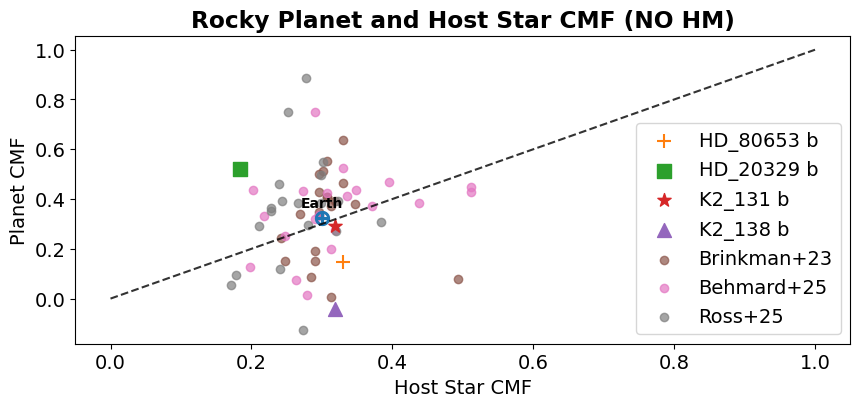

In [70]:
plt.rcParams['font.size'] = 14

plt.figure(figsize=(10,4))
plt.title("Rocky Planet and Host Star CMF (NO HM)", fontweight="bold")
    
markers = ["+", "s", "*", "^"]

plt.scatter(0.30, 0.325, marker=r"$\oplus$", s=100)
plt.text(0.30, 0.366, "Earth", ha="center", fontsize=10, fontweight="bold")

for i in range(len(markers)):
    planet = bz.index[i]
    row = bz.loc[planet]
    plt.scatter(row["Star_CMF"], row["Planet CMF"], label=planet, marker=markers[i], s=100)

plt.scatter(brinkman["Star_CMF"].values, brinkman["Planet CMF"].values, zorder=-1, alpha=0.7, label="Brinkman+23")
plt.scatter(behmard["Star_CMF"].values, behmard["Planet CMF"].values, zorder=-1, alpha=0.7, label="Behmard+25")
plt.scatter(ross["Star_CMF"].values, ross["Planet CMF"].values, zorder=-1, alpha=0.7, label="Ross+25")

plt.plot([0,1], [0,1], color="black", linestyle="dashed", alpha=0.8)
plt.xlabel("Host Star CMF")
plt.ylabel("Planet CMF")
plt.legend(ncol=1)
plt.show()

USED FE 1 lines

Then, each star will have "True" abundances, radius, mass parameters. Each survey will have bias and inflation fraction (for error bars) parameters, and one for each parameter (so 8 parameters per survey)

We will ignore the stellar CMF uncertainty for the dummy first solution since its an order of magnitude smaller
- Should be able to use Wasi's package on this in two lines

Let's use Brinkman and Behmard for the practice one

In [76]:
print(ross["mass"] - ross["Planet Mass"])
print(ross["rad"] - ross["Planet Radius"])

pl_name
HD 136352 b    -0.026570
HD 15337 b     -1.034851
HD 213885 b     0.617268
HD 219134 b     0.047620
HD 219134 c     0.020673
HD 80653 b     -0.033293
K2-106 b        0.462678
K2-131 b       -0.060421
K2-141 b       -0.378328
K2-229 b       -0.172094
K2-265 b        0.601415
K2-291 b       -0.016618
K2-38 b         0.087558
Kepler-10 b    -0.353596
Kepler-107 c   -0.145458
Kepler-20 b     0.223384
Kepler-78 b    -0.126719
Kepler-93 b     0.078753
WASP-47 e      -0.024719
dtype: float64
pl_name
HD 136352 b     0.044122
HD 15337 b      0.136143
HD 213885 b    -0.000584
HD 219134 b     0.107938
HD 219134 c     0.041839
HD 80653 b      0.000767
K2-106 b        0.012470
K2-131 b        0.262341
K2-141 b       -0.057193
K2-229 b       -0.028830
K2-265 b        0.083128
K2-291 b        0.026777
K2-38 b        -0.015445
Kepler-10 b    -0.025635
Kepler-107 c    0.005431
Kepler-20 b     0.013873
Kepler-78 b    -0.035861
Kepler-93 b    -0.036267
WASP-47 e      -0.041666
dtype: float64


In [72]:
display(behmard[["rad","mass","Star_CMF", "Planet Radius", "Planet Mass", "Planet CMF"]])

,rad,mass,Star_CMF,Planet Radius,Planet Mass,Planet CMF
pl_name,,,,,,
CoRoT-7 b,1.528000,6.056000,0.335742,1.559154,5.875618,0.412609
K2-106 b,1.710000,8.530000,0.347799,1.663236,7.892885,0.436302
K2-141 b,1.510000,4.970000,0.307021,1.501893,5.120210,0.424603
K2-216 b,1.750000,8.000000,0.512291,1.665421,7.848054,0.427071
K2-265 b,1.708249,7.341836,0.290234,1.625120,6.258697,0.318202
K2-291 b,1.582000,6.400000,0.395404,1.572697,6.509279,0.469500
K2-38 b,1.655000,7.700000,0.438304,1.670445,7.562606,0.385343
Kepler-10 b,1.470000,3.260000,0.198071,1.481786,3.587363,0.126151
Kepler-100 b,1.344000,5.444916,0.329929,1.364762,3.929218,0.525741
